# Imports

In [141]:
import numpy as np
import cv2
import os 
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
import shutil
from skimage.feature import greycomatrix, greycoprops 
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, f1_score, cohen_kappa_score

from keras.models import Sequential
from keras.layers import Dense
from keras.utils import to_categorical

In [142]:
df  = pd.read_excel("data.xlsx")

In [143]:
df.head(10)

ID  Patient Age Patient Sex Left-Fundus Right-Fundus  \
0   0           69      Female  0_left.jpg  0_right.jpg   
1   1           57        Male  1_left.jpg  1_right.jpg   
2   2           42        Male  2_left.jpg  2_right.jpg   
3   3           66        Male  3_left.jpg  3_right.jpg   
4   4           53        Male  4_left.jpg  4_right.jpg   
5   5           50      Female  5_left.jpg  5_right.jpg   
6   6           60        Male  6_left.jpg  6_right.jpg   
7   7           60      Female  7_left.jpg  7_right.jpg   
8   8           59        Male  8_left.jpg  8_right.jpg   
9   9           54        Male  9_left.jpg  9_right.jpg   

                            Left-Diagnostic Keywords  \
0                                           cataract   
1                                      normal fundus   
2  laser spot，moderate non proliferative retinopathy   
3                                      normal fundus   
4                        macular epiretinal membrane   
5             moderate non proliferative retinopathy   
6                        macular epiretinal membrane   
7                                             drusen   
8                                      normal fundus   
9                                      normal fundus   

                           Right-Diagnostic Keywords  N  D  G  C  A  H  M  O  
0                                      normal fundus  0  0  0  1  0  0  0  0  
1                                      normal fundus  1  0  0  0  0  0  0  0  
2             moderate non proliferative retinopathy  0  1  0  0  0  0  0  1  
3                    branch retinal artery occlusion  0  0  0  0  0  0  0  1  
4                  mild nonproliferative retinopathy  0  1  0  0  0  0  0  1  
5             moderate non proliferative retinopathy  0  1  0  0  0  0  0  0  
6  moderate non proliferative retinopathy，epireti...  0  1  0  0  0  0  0  1  
7                  mild nonproliferative retinopathy  0  1  0  0  0  0  0  1  
8                                      normal fundus  1  0  0  0  0  0  0  0  
9                              vitreous degeneration  0  0  0  0  0  0  0  1

In [144]:
df1  = df.loc[(df['N'] == 1) | (df["C"] ==1)| (df["D"] ==1)]

# Enviroment variables

In [145]:
df1.head()

ID  Patient Age Patient Sex Left-Fundus Right-Fundus  \
0   0           69      Female  0_left.jpg  0_right.jpg   
1   1           57        Male  1_left.jpg  1_right.jpg   
2   2           42        Male  2_left.jpg  2_right.jpg   
4   4           53        Male  4_left.jpg  4_right.jpg   
5   5           50      Female  5_left.jpg  5_right.jpg   

                            Left-Diagnostic Keywords  \
0                                           cataract   
1                                      normal fundus   
2  laser spot，moderate non proliferative retinopathy   
4                        macular epiretinal membrane   
5             moderate non proliferative retinopathy   

                Right-Diagnostic Keywords  N  D  G  C  A  H  M  O  
0                           normal fundus  0  0  0  1  0  0  0  0  
1                           normal fundus  1  0  0  0  0  0  0  0  
2  moderate non proliferative retinopathy  0  1  0  0  0  0  0  1  
4       mild nonproliferative retinopathy  0  1  0  0  0  0  0  1  
5  moderate non proliferative retinopathy  0  1  0  0  0  0  0  0

In [146]:


# Images file names
file_names = []

# Loaded data
training_images = []
flags = []

# Features
grayscaled_images = []
inverted_images = []
thresholded_images = []
gray_histogram_of_images = []
RGB_histogram_of_images = []
conny_edged_images = []
laplacian_edged_images = []
x_edged_images = []
y_edged_images = []
Clahe_images = []

threshold_mean = []
threshold_median = []
threshold_std_dev = []

canny_mean = []
canny_median = []
canny_std_dev = []

# Filtering Cataract & Healthy eyes from others

In [147]:
classes={'Pre_Cataract - Copy':1,"Pre_Normal - Copy":0}

In [148]:

labels = []
file_names.clear()
labels.clear()

for name in classes:
    address='C:/Users/Abhishek/Desktop/PRIMI project/ODIR-5K/' +name
    
    for add in os.listdir(address):
            
            image = cv2.imread(address+'/'+add)
            image = cv2.resize(image, (224,224))
            image = cv2.normalize(image, None, alpha = 0, beta = 255, norm_type = cv2.NORM_MINMAX, dtype =cv2.CV_8U)
            file_names.append(image)
            labels.append(classes[name])
        
  





Subtracting the dataset mean serves to "center" the data. Additionally, you ideally would like to divide by the sttdev of that feature or pixel as well if you want to normalize each feature value to a z-score.

The reason we do both of those things is because in the process of training our network, we're going to be multiplying (weights) and adding to (biases) these initial inputs in order to cause activations that we then backpropogate with the gradients to train the model.

We'd like in this process for each feature to have a similar range so that our gradients don't go out of control (and that we only need one global learning rate multiplier).

Another way you can think about it is deep learning networks traditionally share many parameters - if you didn't scale your inputs in a way that resulted in similarly-ranged feature values (ie: over the whole dataset by subtracting mean) sharing wouldn't happen very easily because to one part of the image weight w is a lot and to another it's too small.

You will see in some CNN models that per-image whitening is used, which is more along the lines of your thinking.


In [149]:
print("Data Length =",len(file_names), "files", len(labels), "labels")

Data Length = 1204 files 1204 labels


# Cataract Ratio

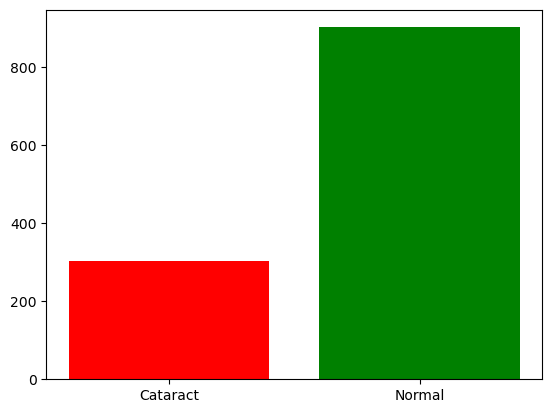

In [150]:
plt.bar([0,1], [len([i for i in labels if i == 1]), len([i for i in labels if i == 0])], color = ['r', 'g'])
plt.xticks([0, 1], ['Cataract', 'Normal'])
plt.show()

# Loading Images

In [151]:
training_images=file_names

training_images = (np.array(training_images))

In [152]:
df2 = pd.DataFrame({'label':labels})
print (df2)

      label
0         1
1         1
2         1
3         1
4         1
...     ...
1199      0
1200      0
1201      0
1202      0
1203      0

[1204 rows x 1 columns]


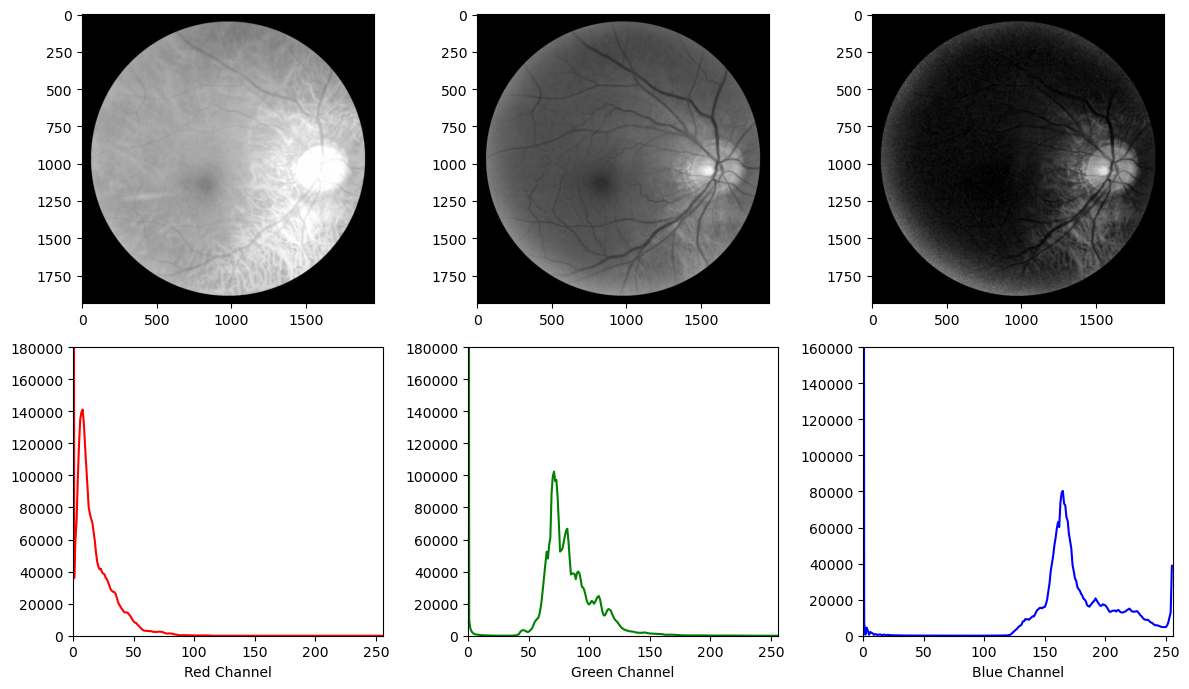

In [153]:
import cv2
import matplotlib.pyplot as plt
image = cv2.imread('329_right.jpg')
image  = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
r,g,b = cv2.split(image) 

plt.figure(figsize=(12,7))  

plt.subplot(2,3,1)
plt.imshow(r,cmap = "gray")

    
plt.subplot(2,3,2)
plt.imshow(g,cmap = "gray")

    
plt.subplot(2,3,3)
plt.imshow(b,cmap = "gray")

        
plt.subplot(2,3,4)
hist = cv2.calcHist([b], [0], None, [256], [0, 256])
plt.plot(hist, color = "r")
plt.xlim([0, 256])
plt.ylim([0, 180000])
plt.xlabel('Red Channel')
    
        
plt.subplot(2,3,5)
hist = cv2.calcHist([g], [0], None, [256], [0, 256])
plt.plot(hist, color = "g")
plt.xlim([0, 256])
plt.ylim([0, 180000])
plt.xlabel('Green Channel')
    
plt.subplot(2,3,6)
hist = cv2.calcHist([r], [0], None, [256], [0, 256])
plt.plot(hist, color = "b")
plt.xlim([0, 256])
plt.ylim([0, 160000])
plt.xlabel('Blue Channel')
    


    
plt.tight_layout()


## Denoising

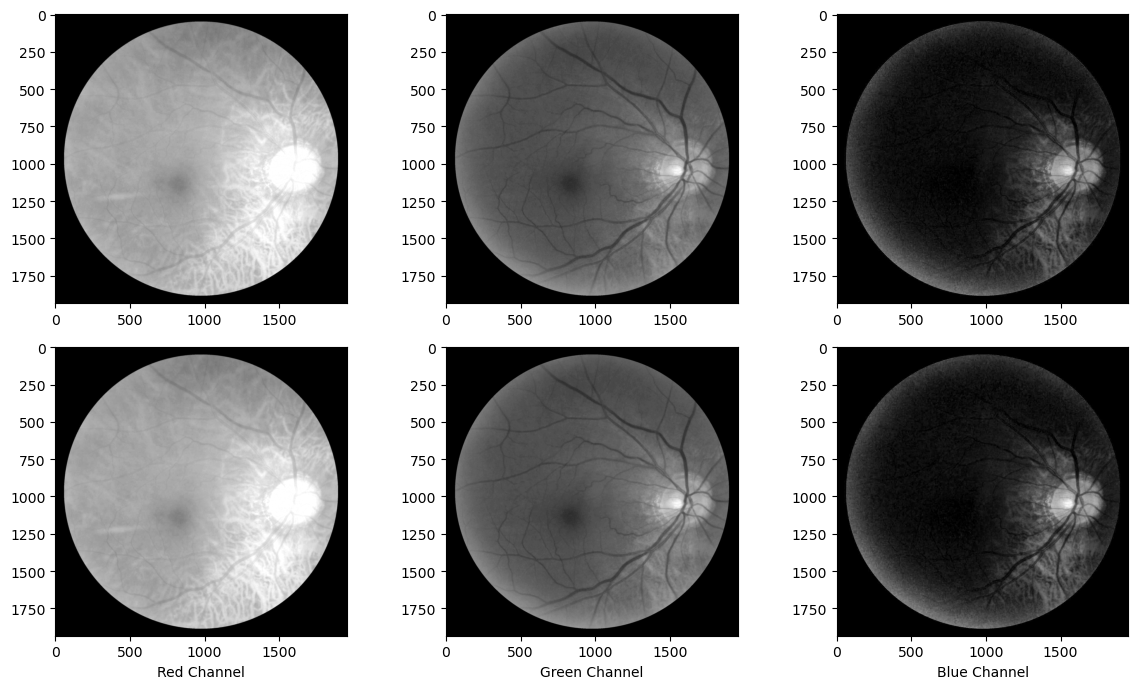

In [154]:
import numpy as np
img = cv2.imread('8_left.jpg')
median = cv2.medianBlur(img, 5)
# compare = np.concatenate((img, median), axis=1) #side by side comparison


plt.figure(figsize=(12,7))  

plt.subplot(2,3,1)
plt.imshow(r,cmap = "gray")
    
plt.subplot(2,3,2)
plt.imshow(g,cmap = "gray")

    
plt.subplot(2,3,3)
plt.imshow(b,cmap = "gray")

        
plt.subplot(2,3,4)
median = cv2.medianBlur(r, 5)
plt.imshow(median,cmap = "gray")
plt.xlabel('Red Channel')
    
        
plt.subplot(2,3,5)
median = cv2.medianBlur(g, 5)
plt.imshow(median,cmap = "gray")
plt.xlabel('Green Channel')
    
plt.subplot(2,3,6)
median = cv2.medianBlur(b, 5)
plt.imshow(median,cmap = "gray")
plt.xlabel('Blue Channel')
    


    
plt.tight_layout()

# Images Sample

(1204, 224, 224, 3)
uint8


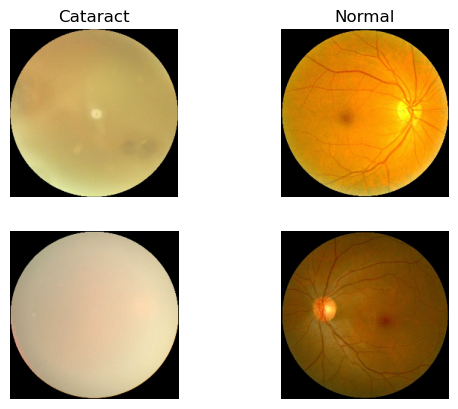

In [155]:
def showSamples(images, gray = False):
    figure, axes = plt.subplots(2, 2)
    axes[0, 0].title.set_text("Cataract")
    axes[0, 1].title.set_text("Normal")
    
    axes[0, 0].axis('off')
    axes[0, 1].axis('off')
    axes[1, 0].axis('off')
    axes[1, 1].axis('off')
    
    axes[0, 0].imshow(images[0],cmap='gray') if gray else axes[0, 0].imshow(cv2.cvtColor(images[0], cv2.COLOR_BGR2RGB))
    axes[0, 1].imshow(images[416],cmap='gray') if gray else axes[0, 1].imshow(cv2.cvtColor(images[416], cv2.COLOR_BGR2RGB))
    axes[1, 0].imshow(images[2],cmap='gray') if gray else axes[1, 0].imshow(cv2.cvtColor(images[2], cv2.COLOR_BGR2RGB))
    axes[1, 1].imshow(images[512],cmap='gray') if gray else axes[1, 1].imshow(cv2.cvtColor(images[512], cv2.COLOR_BGR2RGB))
    plt.show()

print(np.array(training_images).shape)
print(training_images[161].dtype)
showSamples(training_images)

In [156]:
def vis(images,operated_images,label):
    plt.figure(figsize=(12,7))    
    plt.subplot(2,4,1)
    plt.imshow( cv2.cvtColor(images[0], cv2.COLOR_BGR2RGB))
    plt.xlabel('Cataract')
    
    plt.subplot(2,4,2)
    plt.imshow(cv2.cvtColor(images[8], cv2.COLOR_BGR2RGB))
    plt.xlabel('Cataract')
    
    plt.subplot(2,4,3)
    plt.imshow(cv2.cvtColor(images[411], cv2.COLOR_BGR2RGB))
    plt.xlabel(' Normal ')
        
    plt.subplot(2,4,4)
    plt.imshow(cv2.cvtColor(images[788], cv2.COLOR_BGR2RGB))
    plt.xlabel(' Normal ')
    
        
    plt.subplot(2,4,5)
    plt.imshow( operated_images[0],cmap='gray')
    plt.xlabel(f'Cataract After {label}')
    
    plt.subplot(2,4,6)
    plt.imshow(operated_images[8],cmap='gray')
    plt.xlabel(f'Cataract After {label}')
    
    plt.subplot(2,4,7)
    plt.imshow(operated_images[411],cmap='gray')
    plt.xlabel(f'  Normal After {label}')
        
    plt.subplot(2,4,8)
    plt.imshow(operated_images[788],cmap='gray')
    plt.xlabel(f'  Normal After {label}')
        
    
    plt.tight_layout()

# Feature Extraction

##  Grayscaling

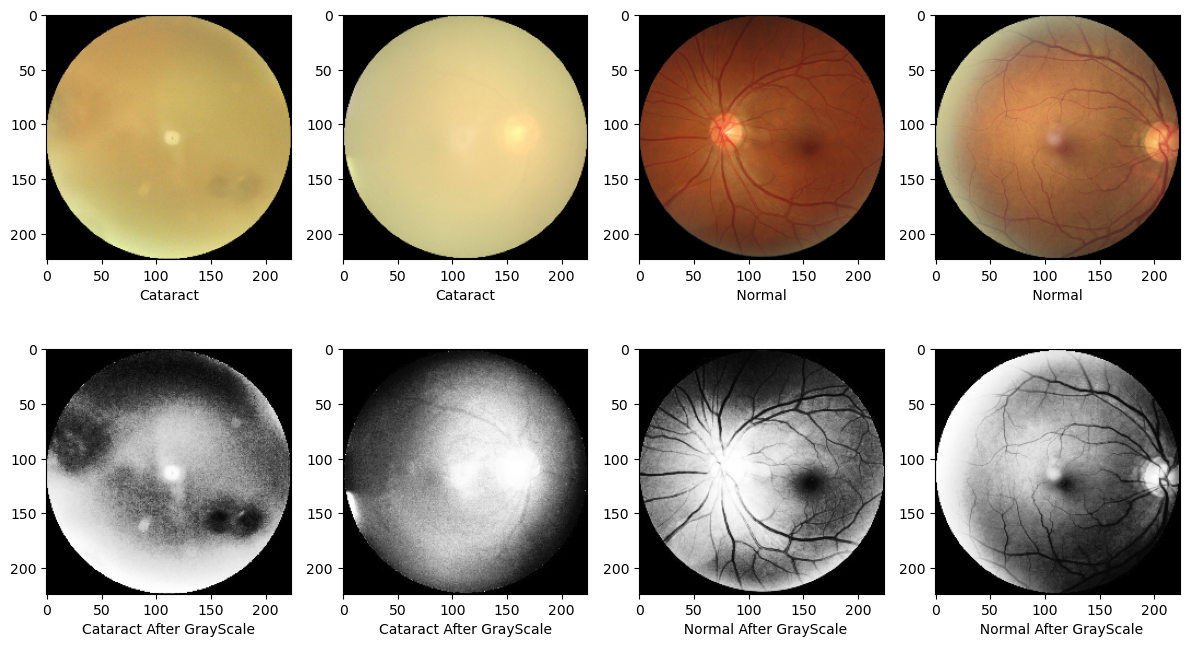

In [157]:
grayscaled_images.clear()
for idx, image in enumerate(training_images):
    r,g,b = cv2.split(image)
#     g = cv2.medianBlur(g, 5)
    g= cv2.equalizeHist(g)
    gray_image = cv2.normalize(src=g, dst=None, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_8U)
    grayscaled_images.append(gray_image)

vis(training_images,grayscaled_images,'GrayScale')



##  Thresholding

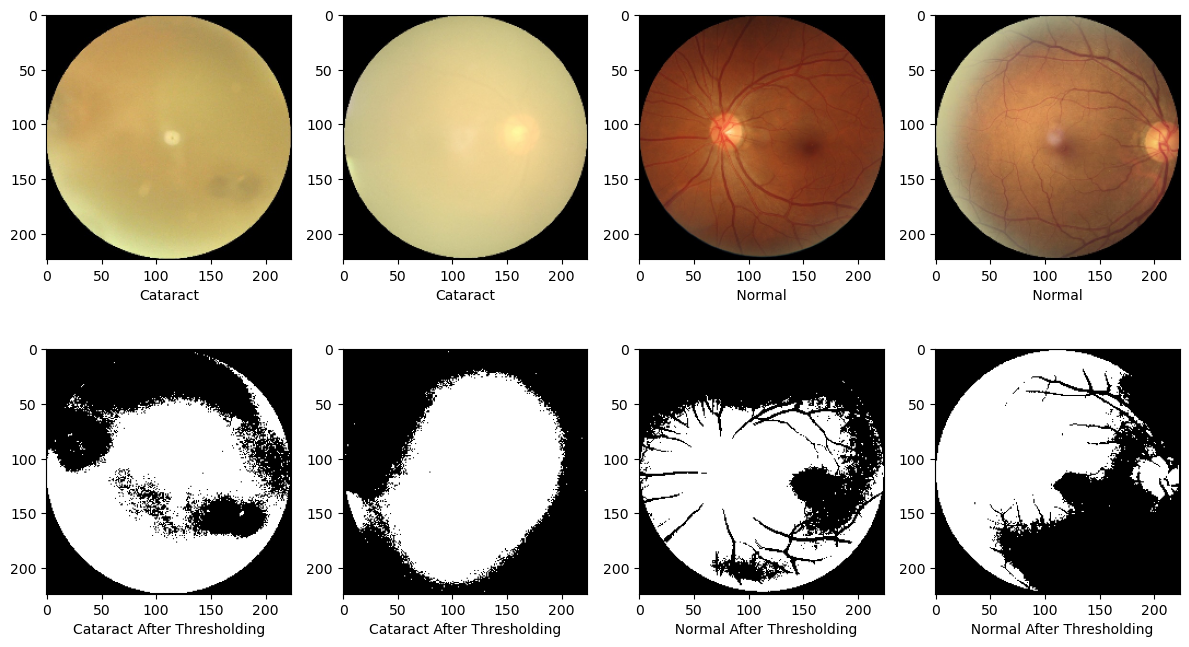

In [158]:
thresholded_images.clear()
kernel = np.ones((5,5),np.uint8)
for idx, image in enumerate(grayscaled_images):
    thresh, binaryImg = cv2.threshold(image, 0, 255, cv2.THRESH_OTSU)
    ret, image = cv2.threshold(binaryImg,thresh+90,255,cv2.THRESH_TOZERO)
#     image = cv2.dilate(image,kernel,iterations = 3)
#     image = cv2.erode(image,kernel,iterations = 3)
    thresholded_images.append(image)

# showSamples(thresholded_images, True)
vis(training_images,thresholded_images,'Thresholding')

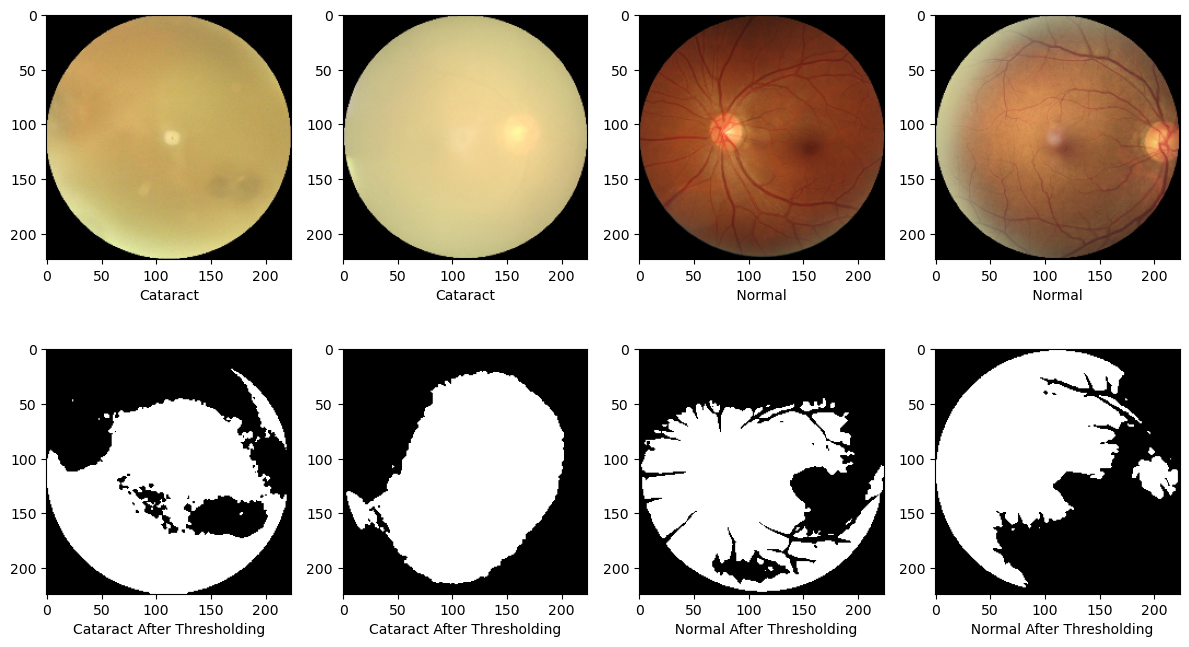

In [159]:
otsu_images = []
for idx, image in enumerate(grayscaled_images):
    blur = cv2.GaussianBlur(image,(5,5),0)
    tret2,th2 = cv2.threshold(blur,60,255,cv2.THRESH_OTSU)
    otsu_images.append(th2)

# showSamples(thresholded_images, True)
vis(training_images,otsu_images,'Thresholding')


## Histogram Equalization

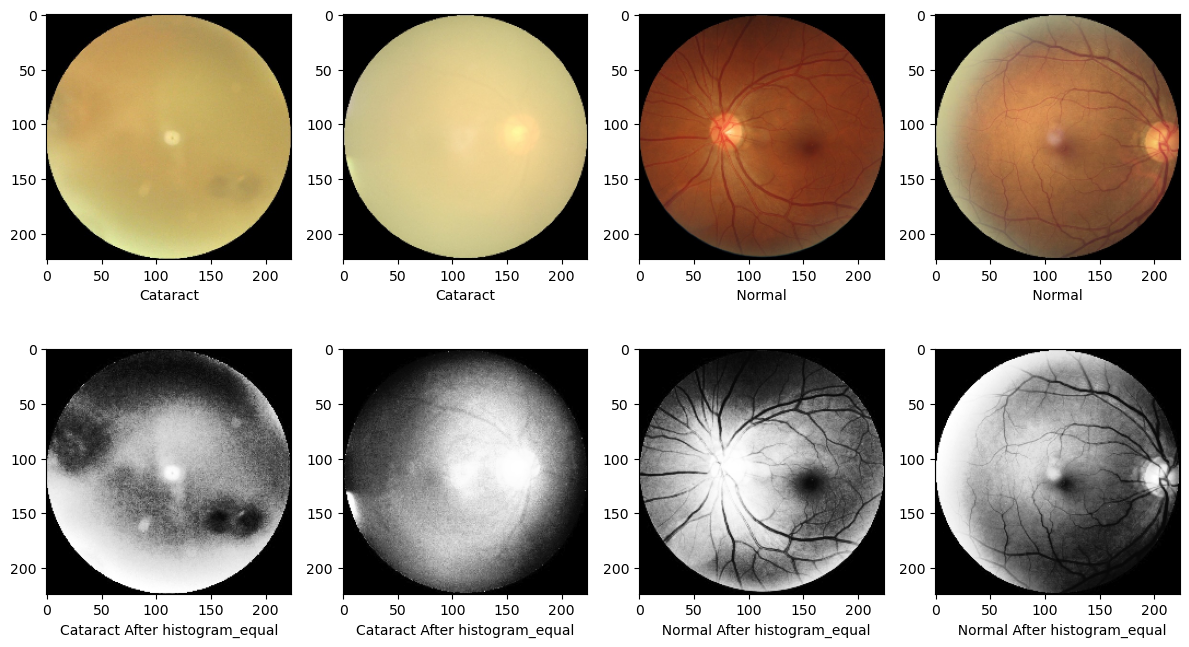

In [160]:
gray_histogram_of_images.clear()
for image in training_images:
    
    r,g,b = cv2.split(image)
    image_histogram = cv2.equalizeHist(g)
    gray_histogram_of_images.append(image_histogram)

vis(training_images,gray_histogram_of_images,'histogram_equal')

## CLAHE image

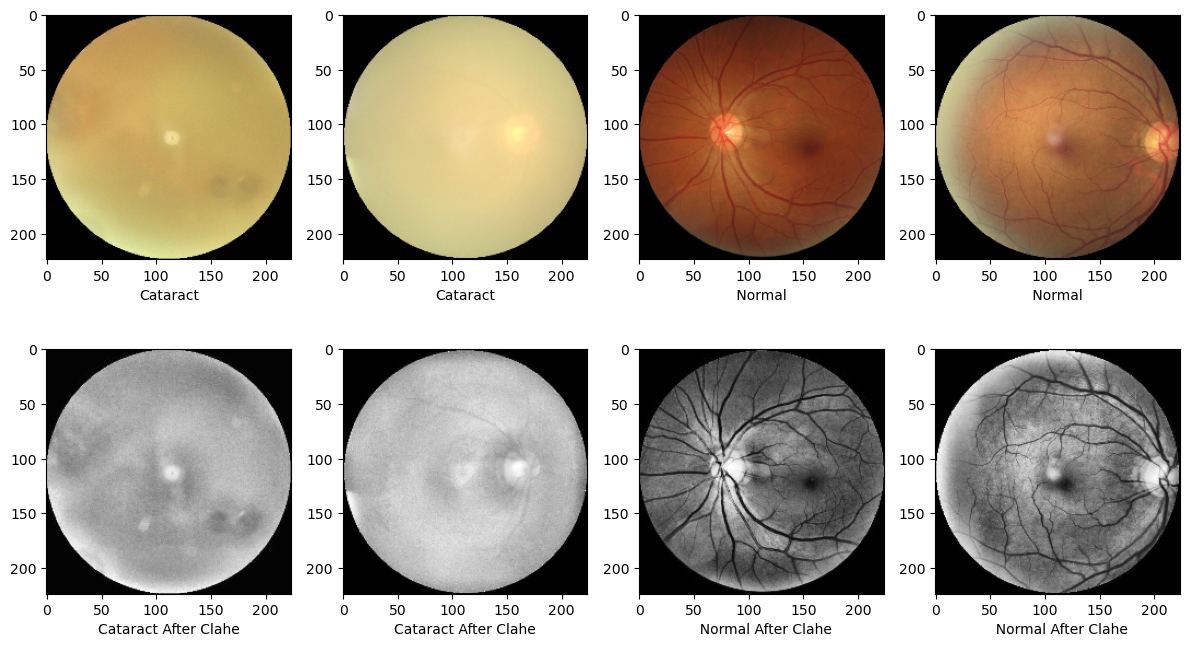

In [161]:
Clahe_images.clear()
num_white2 = []


for idx, image in enumerate(training_images):
    R, G, B = cv2.split(image)
    
    clahe = cv2.createCLAHE(clipLimit = 5)
    clahe_img = clahe.apply(G) 
    Clahe_images.append(clahe_img)
    W = np.sum(image == 255)
    B = np.sum(image == 0)
    num_white2.append((W*1000)/(W+B) )

vis(training_images,Clahe_images,'Clahe')
dfwh = pd.DataFrame({' num_white2': num_white2})

## Canny Edge detection

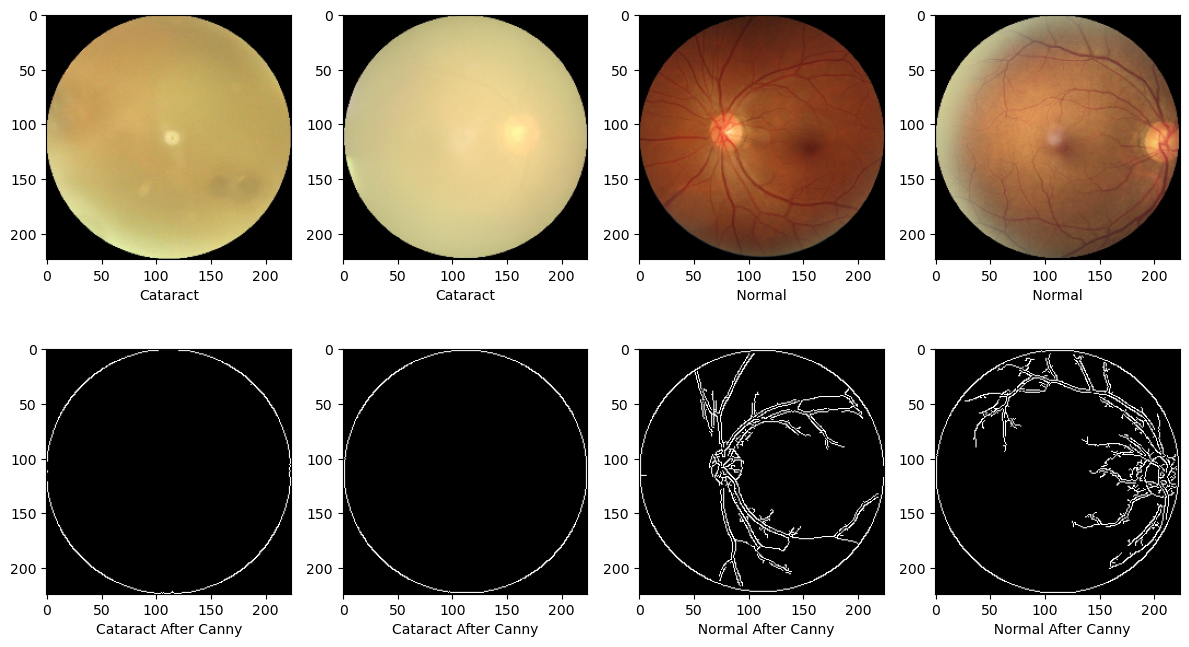

In [162]:
canny_edged_images = []
num_white = []


for image in training_images:
    image = cv2.Canny(image,30,200)
    canny_edged_images.append(image)
    W = np.sum(image == 255)
    B = np.sum(image == 0)
    num_white.append(W/(W+B) )
    
vis(training_images,canny_edged_images,'Canny')
dfwhite = pd.DataFrame({' num_white': num_white})


## Sobel filter mag

In [163]:
sod_images = []
sob_mag = []


for image in grayscaled_images:
    gx = cv2.Sobel(image, cv2.CV_32F, 1, 0, ksize=1);
    gy = cv2.Sobel(image, cv2.CV_32F, 0, 1, ksize=1);
    mag, angle = cv2.cartToPolar(gx, gy, angleInDegrees=True);
    sob_mag.append(np.sum(angle/10000))
#     print(([(number_of_white_pix)/(number_of_white_pix +number_of_black_pix)]*100 ))
    
# vis(training_images,canny_edged_images,'Canny')
dfsob_mag = pd.DataFrame({' sob_mag': sob_mag})

print(f"magnitude of Sobel on Cataract is {sob_mag[0]}")
print(f"magnitude of Sobel on Normal is {sob_mag[800]}")

magnitude of Sobel on Cataract is 569.8976440429688
magnitude of Sobel on Normal is 682.7461547851562


(0.0, 75.0)

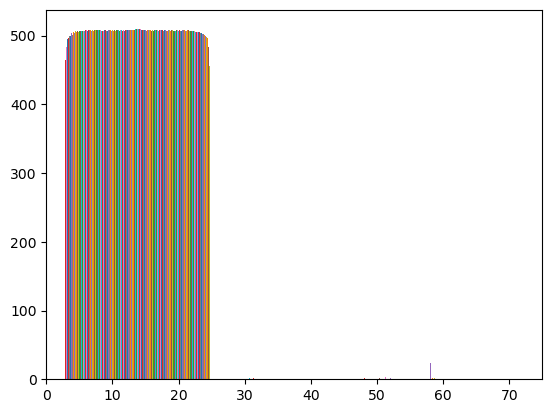

In [164]:
im = cv2.imread('3029_left.jpg')
r,im1,b = cv2.split(im)
# im1 = np.float32(im1) / 255.0

# Calculate gradient

gx = cv2.Sobel(im1, cv2.CV_32F, 1, 0, ksize=1);

gy = cv2.Sobel(im1, cv2.CV_32F, 0, 1, ksize=1);

# Python Calculate gradient magnitude and direction ( in degrees )

mag, angle = cv2.cartToPolar(gx, gy, angleInDegrees=True);
plt.hist(mag)
plt.xlim([0,75])


In [165]:
np.sum(mag)

1062258.2

## Erosion

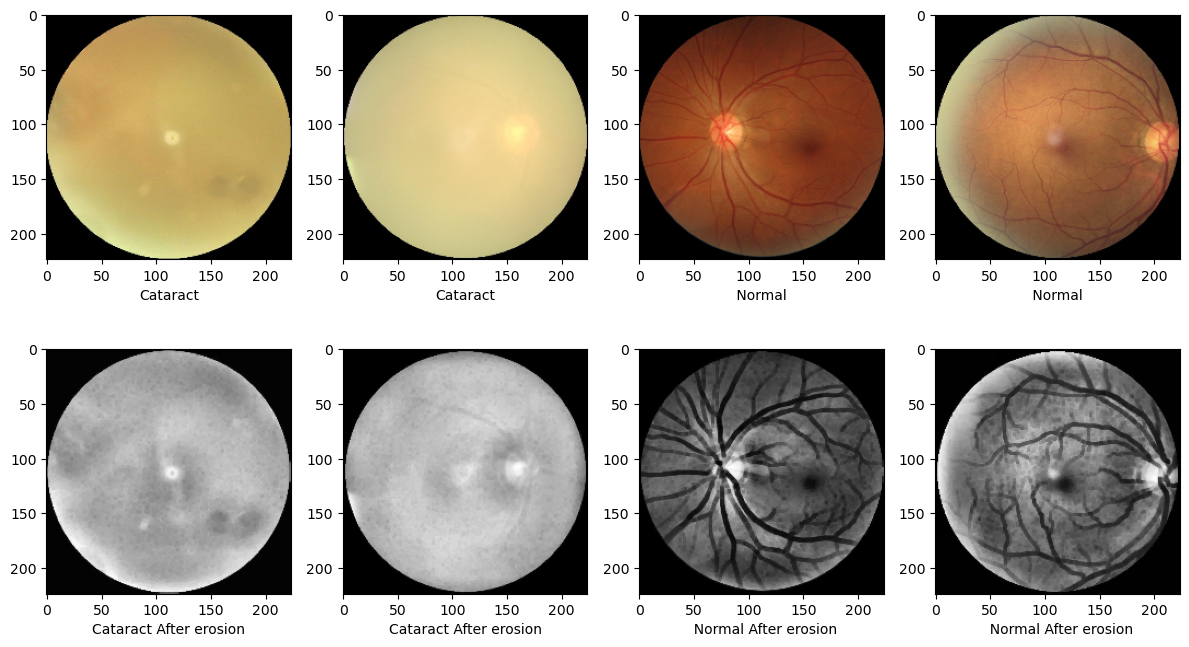

In [166]:
ero_images = []
ero_images.clear()
kernel = np.ones((3,3),np.uint8)
for idx, image in enumerate(Clahe_images):
    
    erosion = cv2.erode(image,kernel,iterations = 1)
    ero_images.append(erosion)

vis(training_images,ero_images,'erosion')

## Dilation

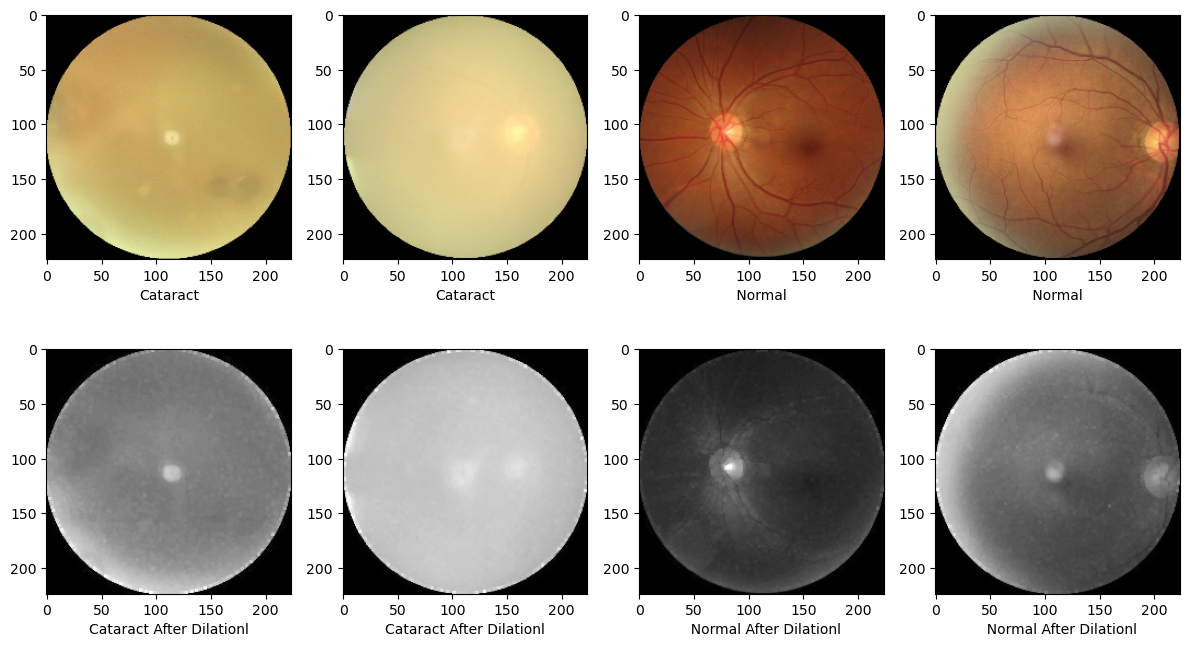

In [247]:
dil_images = []
dil_images.clear()
kernel = np.ones((3,3),np.uint8)
for idx, image in enumerate(training_images):
    r,g,b = cv2.split(image)
    dilation = cv2.dilate(r,kernel,iterations = 1)
    dil_images.append(dilation)

# showSamples(dil_images, True)
vis(training_images,dil_images,'Dilationl')

In [169]:
dl_mean=[]
dl_median=[]
dl_std_dev=[]

for idx, image in enumerate(dil_images):
    mean = np.mean(image)
    median = np.median(image)
    std_dev = np.std(image)
    
    dl_mean.append(mean)
    dl_median.append(median)
    dl_std_dev.append(std_dev)
    
dfdl = pd.DataFrame({'dl_mean':dl_mean})
dfdl_median = pd.DataFrame({'dl_std_dev':dl_median})
dfdl_std_dev = pd.DataFrame({'dl_std_dev':dl_std_dev})


## Bottom Hat

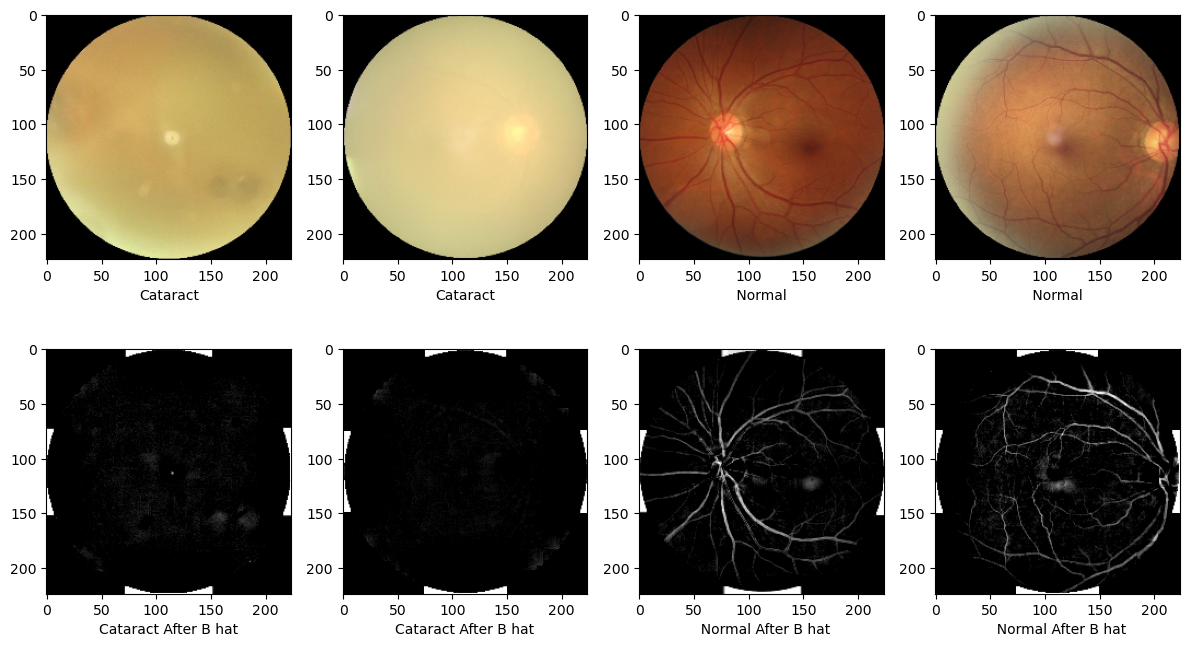

In [171]:
B_images = []
B_images.clear()
from skimage.filters import unsharp_mask
for idx, image in enumerate(training_images):

    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    rectKernel = cv2.getStructuringElement(cv2.MORPH_RECT, (15, 15))
    blackhat = cv2.morphologyEx(gray, cv2.MORPH_BLACKHAT, rectKernel)
#     blackhat = cv2.dilate(blackhat,kernel,iterations = 1)
    
    blackhat = unsharp_mask(blackhat, radius=20, amount=5)
#     blackhat = cv2.dilate(blackhat,kernel,iterations = 1)
#     B_images.append(blackhat>2)
    B_images.append(blackhat)
vis(training_images, B_images,'B hat')

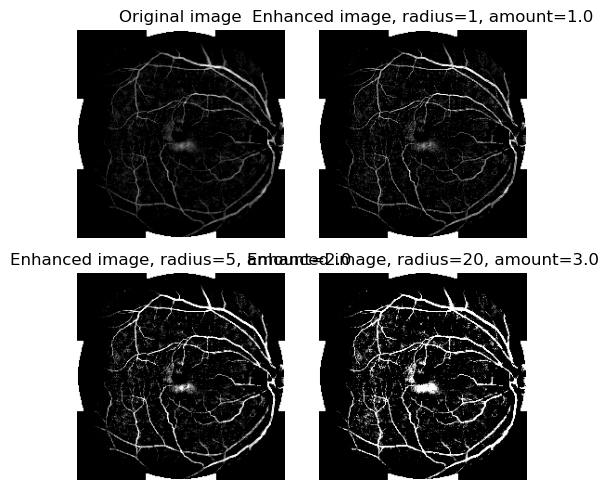

In [248]:
from skimage import data
from skimage.filters import unsharp_mask
import matplotlib.pyplot as plt

image = B_images[788]
result_1 = unsharp_mask(image, radius=1, amount=1)
result_2 = unsharp_mask(image, radius=5, amount=2)
result_3 = unsharp_mask(image, radius=20, amount=5)


fig, axes = plt.subplots(nrows=2, ncols=2,
                         sharex=True, sharey=True, figsize=(5,5))
ax = axes.ravel()

ax[0].imshow(image, cmap=plt.cm.gray)
ax[0].set_title('Original image')
ax[1].imshow(result_1, cmap=plt.cm.gray)
ax[1].set_title('Enhanced image, radius=1, amount=1.0')
ax[2].imshow(result_2, cmap=plt.cm.gray)
ax[2].set_title('Enhanced image, radius=5, amount=2.0')
ax[3].imshow(result_3, cmap=plt.cm.gray)
ax[3].set_title('Enhanced image, radius=20, amount=3.0')

for a in ax:
    a.axis('off')
fig.tight_layout()
plt.show()

**By using Bottom-hat transform, it is possible to
obtain details of the image as the edge, surface and size.
This process allows extracting the dark features..**

## Top hat

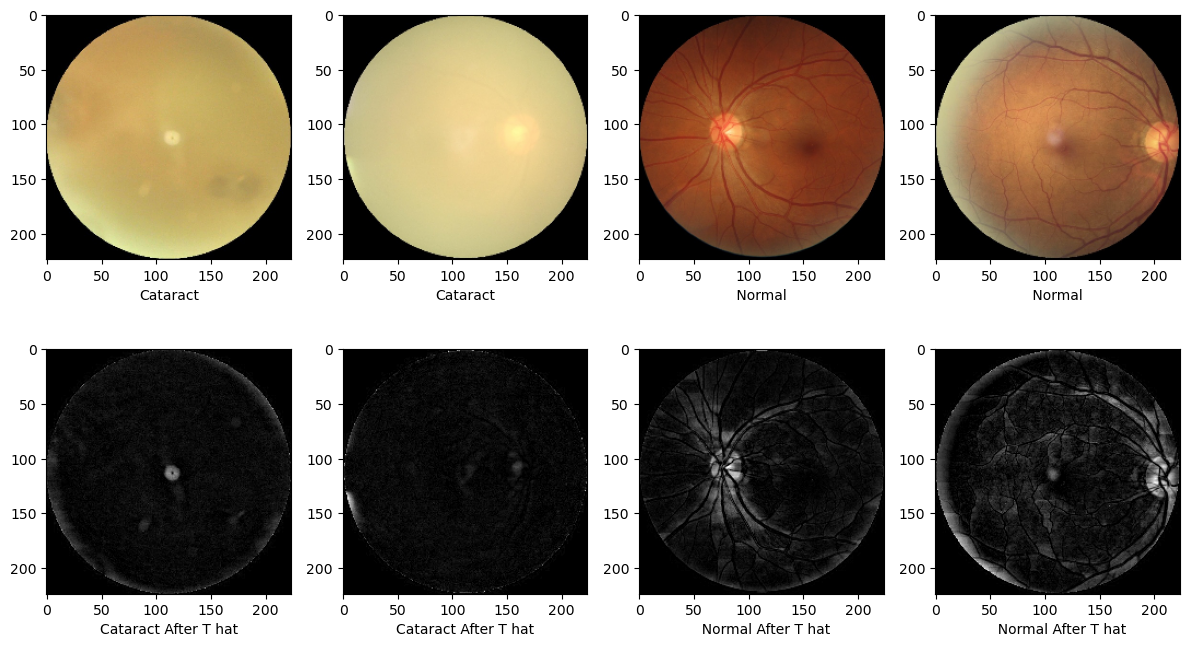

In [173]:
T_images = []
T_images.clear()
for idx, image in enumerate(training_images):

    gray = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    rectKernel = cv2.getStructuringElement(cv2.MORPH_RECT, (13, 5))
    tophat = cv2.morphologyEx(image, cv2.MORPH_TOPHAT, rectKernel)
    tophat = cv2.cvtColor(tophat, cv2.COLOR_RGB2GRAY)
    
    T_images.append(tophat)
    
vis(training_images, T_images,'T hat')

In [204]:
T_images[1].shape

(224, 224)

**It is used for highlighting white object against dark background**

## GLCM

In [205]:
Energy = []
Correlation = []
Dissimilarity = []
Homogenity = []
Contrast = []


def energy(img):
          
            img = np.array(img)
            GLCM = greycomatrix(img, [1], [0])       
            return greycoprops(GLCM, 'energy')[0]

def correlation(img):
#           
            img = np.array(img)
            GLCM = greycomatrix(img, [1], [0])       
            return greycoprops(GLCM, 'correlation')[0]
    
def dissimilarity(img):

            img = np.array(img)
            GLCM = greycomatrix(img, [1], [0])      
            return  greycoprops(GLCM, 'dissimilarity')[0]
        
def homogenity(img):

            img = np.array(img)
            GLCM = greycomatrix(img, [1], [0])       
            return  greycoprops(GLCM, 'homogeneity')[0]
    
def contrast(img):

            img = np.array(img)
            GLCM = greycomatrix(img, [1], [0])       
            return greycoprops(GLCM, 'contrast')[0]

        
for img in training_images:
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    Energy.append(energy(img)[0])
    Correlation.append(correlation(img)[0])
    Dissimilarity.append(dissimilarity(img)[0])
    Homogenity.append(homogenity(img)[0])
    Contrast.append(contrast(img)[0])

    

dfe = pd.DataFrame({'Energy':Energy})
dfco = pd.DataFrame({'Correlation':Correlation})
dfd = pd.DataFrame({' Dissimilarity': Dissimilarity})
dfh = pd.DataFrame({'Homogenity':Homogenity})
dfc = pd.DataFrame({'Contrast':Contrast})


In [206]:

er_mean=[]
er_median=[]
er_std_dev=[]
for idx, image in enumerate(ero_images ):
    mean = np.mean(image)
    median = np.median(image)
    std_dev = np.std(image)
    
    er_mean.append(mean)
    er_median.append(median)
    er_std_dev.append(std_dev)

dfer= pd.DataFrame({'er_mean':er_mean})
dfer_median= pd.DataFrame({'er_median':er_median})
dfer_std_dev = pd.DataFrame({'er_std_dev':er_std_dev})


In [207]:
clahe_mean=[]
clahe_median=[]
clahe_std_dev=[]

clahe_mean.clear()
clahe_median.clear()
clahe_std_dev.clear()

for image in Clahe_images:
    mean = np.mean(image)
    median = np.median(image)
    std_dev = np.std(image)
    
    clahe_mean.append(mean)
    clahe_median.append(median)
    clahe_std_dev.append(std_dev)
    
dfcl= pd.DataFrame({'clahe_mean':clahe_mean})
dfclahe_median= pd.DataFrame({'clahe_median':clahe_median})
dfclahe_std_dev = pd.DataFrame({'clahe_std_dev':clahe_std_dev})


## F9 Mean, Median, Mode, Standard Deviation of ***Canny***

In [208]:
canny_edged_images = []


for idx, image in enumerate(training_images):
    mean = np.mean(image)
    median = np.median(image)
    std_dev = np.std(image)
    
    canny_mean.append(mean)
    canny_median.append(median)
    canny_std_dev.append(std_dev)

dfca= pd.DataFrame({'canny_mean':canny_mean})
dfconny_median= pd.DataFrame({'conny_median':canny_median})
dfconny_std_dev= pd.DataFrame({'canny_std_dev':canny_std_dev})


In [209]:
# pdList = [dfwhite,dfBHwhite,dfsob_mag,dfe,dfc,dfd,dfco,dfh,dfer,dfer_median,dfer_std_dev,dfdl,dfdl_std_dev,dfdl_median
#           ,dfcl,dfclahe_median,dfclahe_std_dev,
#           dfca,dfconny_median,dfconny_std_dev,dfwhite,df2]  

# new_df = pd.concat(pdList,axis=1)

In [215]:
pdList = [dfwhite,dfer,dfsob_mag,dfd,dfh,dfer_median,dfer_std_dev,dfdl,dfdl_std_dev
          ,dfcl,dfwh,df2]  

new_df = pd.concat(pdList,axis=1)

In [216]:
# pdList = [dfe,dfc,dfd,dfco,dfh,df2]  
# new_df = pd.concat(pdList,axis=1)

In [217]:
# pdList = [dfhi,dfhi_median,dfhi_std_dev,dfer,dfer_median,dfer_std_dev,dfdl,dfdl_std_dev,dfdl_median
#           ,dfcl,dfclahe_median,dfclahe_std_dev,dfth,dfthreshold_std_dev,
#           dfca,dfconny_std_dev,df2] 

# new_df = pd.concat(pdList,axis=1)

In [218]:
new_df.head()

num_white     er_mean     sob_mag   Dissimilarity  Homogenity  er_median  \
0    0.015944  124.510662  569.897644        2.900985    0.531859      153.0   
1    0.015705  115.981087  584.967102        2.683116    0.567100      140.0   
2    0.015944  135.971022  621.500671        2.818666    0.558796      170.0   
3    0.016342   84.213429  543.466736        1.713245    0.578155       91.0   
4    0.015705   87.002611  701.855408        2.850937    0.473906       96.0   

   er_std_dev     dl_mean  dl_std_dev  clahe_mean   num_white2  label  
0   67.274746  130.783542   67.677396  134.271963     0.034417      1  
1   66.326749  122.311683   66.903713  125.610272     0.327407      1  
2   75.403161  141.841099   75.113926  146.166813     0.165071      1  
3   54.362687   89.778380   55.901444   92.001016     0.033677      1  
4   47.858605   95.751176   50.396670  101.258012     0.082095      1

In [219]:
new_df.tail()

num_white    er_mean     sob_mag   Dissimilarity  Homogenity  \
1199    0.108658  67.256019  691.190613        3.546785    0.394085   
1200    0.047852  80.555983  626.820251        3.372518    0.469070   
1201    0.042969  72.412946  671.563904        2.690123    0.480215   
1202    0.071488  69.058195  650.372559        3.096593    0.462437   
1203    0.088229  72.385344  683.490845        3.103419    0.451630   

      er_median  er_std_dev    dl_mean  dl_std_dev  clahe_mean   num_white2  \
1199       69.0   47.078322  80.040099   51.183429   87.232522    25.672330   
1200       85.0   55.845368  92.642757   59.754934   96.924207     1.554490   
1201       79.0   47.136165  83.049326   50.419305   88.135523     2.027204   
1202       75.0   45.950910  80.646464   50.037828   86.408681     0.098367   
1203       78.0   49.622136  84.634208   53.750081   90.290338     1.868546   

      label  
1199      0  
1200      0  
1201      0  
1202      0  
1203      0

In [244]:
c = new_df.iloc[:, :-1]
X = new_df.iloc[:, :-1].values
y = new_df.iloc[:, -1].values

# Formating the data for Machine Learning

In [221]:

X_train, X_test, y_train, y_test = train_test_split(X, np.array(y), test_size=0.3, random_state=42)

stdSc = StandardScaler()
X_train = stdSc.fit_transform(X_train)
X_test = stdSc.transform(X_test)

X_train = np.asarray(X_train).astype('float32')
y_train = np.asarray(y_train).astype('float32')

X_test = np.asarray(X_test).astype('float32')
y_test = np.asarray(y_test).astype('float32')

In [222]:
# print(training_features.shape)
print(X_train.shape)
print(y_train.shape)

(842, 11)
(842,)


In [223]:
perform_list = []

![](http://)

In [224]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.multiclass import OneVsRestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC, LinearSVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB,MultinomialNB,BernoulliNB
from sklearn.metrics import precision_recall_fscore_support
# from sklearn.metrics import precision_recall_fscore_support as score

def run_model(model_name, est_c, est_pnlty):

    mdl=''
    
    if model_name == 'Logistic Regression':

        mdl = LogisticRegression()

    elif model_name == 'Random Forest':

        mdl = RandomForestClassifier(n_estimators=500 ,criterion='entropy' , random_state=0)

    elif model_name == 'Multinomial Naive Bayes':

        mdl = MultinomialNB(alpha=1.0,fit_prior=True)

    elif model_name == 'Support Vector Classifer':

        mdl = SVC()

    elif model_name == 'Decision Tree Classifier':

        mdl = DecisionTreeClassifier()

    elif model_name == 'K Nearest Neighbour':

        mdl = KNeighborsClassifier(n_neighbors=9 , metric= 'minkowski' , p = 4)

    elif model_name == 'Gaussian Naive Bayes':

        mdl = GaussianNB()

    mdl.fit(X_train, y_train)
    y_pred = mdl.predict(X_test)

    accuracy = round(accuracy_score(y_test, y_pred) * 100, 2)


      # Performance metrics

    accuracy = round(accuracy_score(y_test, y_pred) * 100, 2)

    # Get precision, recall, f1 scores

    precision, recall, f1score, support = precision_recall_fscore_support(y_test, y_pred, average='weighted')

    print(f'Test Accuracy Score of Basic {model_name}: % {accuracy}')

    print(f'Precision : {precision}')

    print(f'Recall : {recall}')

    print(f'F1-score : {f1score}')

    # Add performance parameters to list

    perform_list.append(dict([

    ('Model', model_name),

    ('Test Accuracy', round(accuracy, 2)),

    ('Precision', round(precision, 2)),

    ('Recall', round(recall, 2)),

    ('F1', round(f1score, 2))

    ]))
    

In [225]:
# run_model('Logistic Regression', est_c=None, est_pnlty=None)

95.3
              precision    recall  f1-score   support

         0.0       0.98      0.96      0.97       271
         1.0       0.89      0.93      0.91        91

    accuracy                           0.95       362
   macro avg       0.93      0.95      0.94       362
weighted avg       0.95      0.95      0.95       362



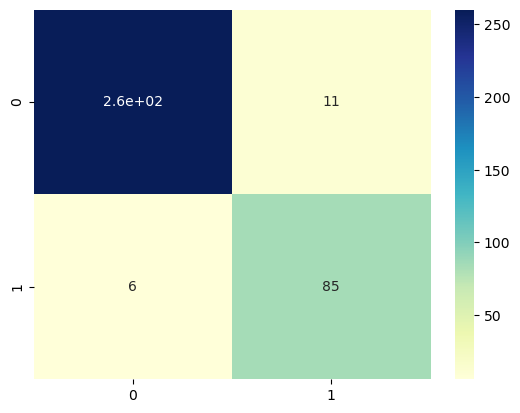

In [226]:
import seaborn as sns
from sklearn.metrics import classification_report
LR = LogisticRegression(penalty= 'l2',random_state=0).fit(X_train, y_train)
LR.fit(X_train, y_train)
y_pred = LR.predict(X_test);
LRaccuracy = round(accuracy_score(y_test, y_pred) * 100, 2)
print(LRaccuracy)
conf1 = confusion_matrix(y_test, y_pred)
sns.heatmap(conf1, cmap="YlGnBu",annot=True)
print(classification_report(y_test,y_pred))

In [227]:
# run_model('Random Forest', est_c=None, est_pnlty=None)

96.69
              precision    recall  f1-score   support

         0.0       0.98      0.98      0.98       271
         1.0       0.93      0.93      0.93        91

    accuracy                           0.97       362
   macro avg       0.96      0.96      0.96       362
weighted avg       0.97      0.97      0.97       362



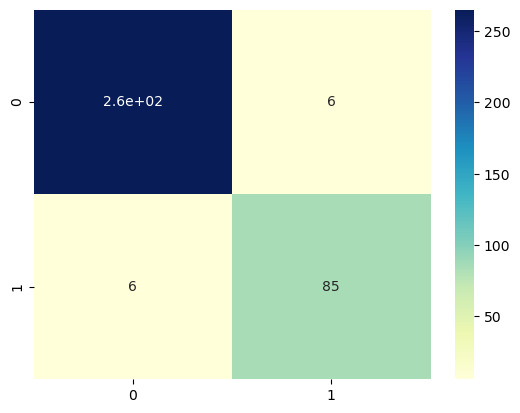

In [228]:
RF = RandomForestClassifier(max_depth=5,n_estimators=20 ,criterion='gini' , random_state=0)
RF.fit(X_train, y_train)
y_pred2 = RF.predict(X_test);
RFaccuracy = round(accuracy_score(y_test, y_pred2) * 100, 2)
print(RFaccuracy)

conf2 = confusion_matrix(y_test, y_pred2)
sns.heatmap(conf2, cmap="YlGnBu",annot=True)
print(classification_report(y_test,y_pred2))

 num_white        0.484703
er_median         0.153125
er_mean           0.123048
dl_mean           0.050221
 Dissimilarity    0.040480
Homogenity        0.038333
 num_white2       0.034915
er_std_dev        0.024519
 sob_mag          0.023423
dl_std_dev        0.017157
clahe_mean        0.010076
dtype: float64


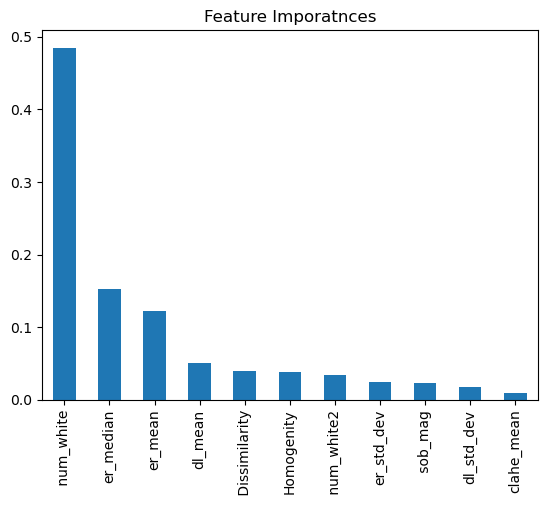

In [246]:
importances = list(RF.feature_importances_)
c.columns
feature_list = list(c.columns)
feature_imp = pd.Series(RF.feature_importances_,index=feature_list).sort_values(ascending=False)
print(feature_imp)
plt.title("Feature Imporatnces")
feature_imp.plot.bar()

plt.show()

In [230]:
run_model('Support Vector Classifer', est_c=None, est_pnlty=None) 

Test Accuracy Score of Basic Support Vector Classifer: % 96.41
Precision : 0.9638594936337606
Recall : 0.9640883977900553
F1-score : 0.9638863018481428


              precision    recall  f1-score   support

         0.0       0.97      0.98      0.98       271
         1.0       0.94      0.91      0.93        91

    accuracy                           0.96       362
   macro avg       0.96      0.95      0.95       362
weighted avg       0.96      0.96      0.96       362



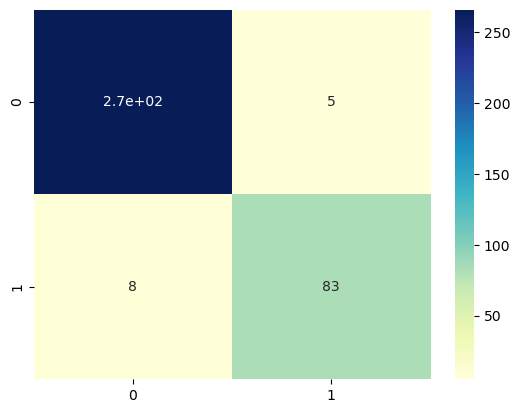

In [231]:
SV = SVC(C=1)
SV.fit(X_train, y_train)
y_pred3 = SV.predict(X_test);
SVaccuracy = round(accuracy_score(y_test, y_pred3) * 100, 2)
SVaccuracy

conf3 = confusion_matrix(y_test, y_pred3)
sns.heatmap(conf3, cmap="YlGnBu",annot=True)
print(classification_report(y_test,y_pred3))

In [232]:
run_model('Decision Tree Classifier', est_c=None, est_pnlty=None)

Test Accuracy Score of Basic Decision Tree Classifier: % 93.37
Precision : 0.9357018272559136
Recall : 0.9337016574585635
F1-score : 0.934388536920429


95.3
              precision    recall  f1-score   support

         0.0       0.97      0.96      0.97       271
         1.0       0.89      0.91      0.90        91

    accuracy                           0.95       362
   macro avg       0.93      0.94      0.93       362
weighted avg       0.95      0.95      0.95       362



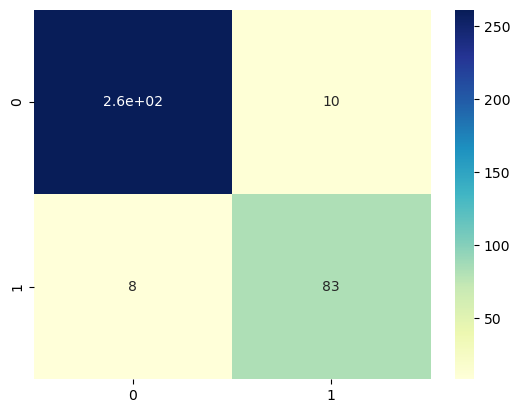

In [233]:
DT = DecisionTreeClassifier(max_depth= 4,random_state=0)
DT.fit(X_train, y_train)
y_pred4 = DT.predict(X_test);
DTaccuracy = round(accuracy_score(y_test, y_pred) * 100, 2)
print(DTaccuracy)

conf4 = confusion_matrix(y_test, y_pred4)
sns.heatmap(conf4, cmap="YlGnBu",annot=True)
print(classification_report(y_test,y_pred4))

In [199]:
run_model('K Nearest Neighbour', est_c=None, est_pnlty=None)

Test Accuracy Score of Basic K Nearest Neighbour: % 93.92
Precision : 0.9403846227886115
Recall : 0.9392265193370166
F1-score : 0.937168981277692


94.75
              precision    recall  f1-score   support

         0.0       0.94      0.99      0.97       271
         1.0       0.96      0.82      0.89        91

    accuracy                           0.95       362
   macro avg       0.95      0.91      0.93       362
weighted avg       0.95      0.95      0.95       362



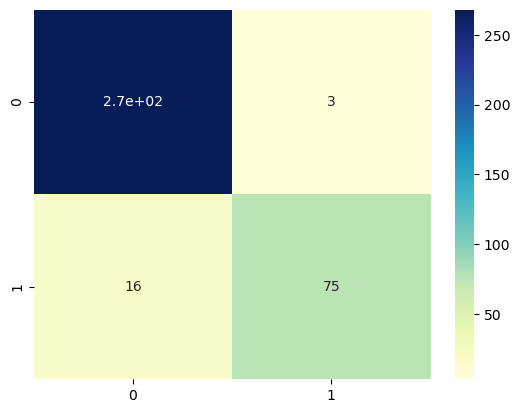

In [200]:
NN = KNeighborsClassifier(n_neighbors=5,metric = "minkowski")
NN.fit(X_train,y_train)
y_pred5 = NN.predict(X_test);
NNaccuracy = round(accuracy_score(y_test, y_pred5) * 100, 2)
print(NNaccuracy)

conf5 = confusion_matrix(y_test, y_pred5)
sns.heatmap(conf5, cmap="YlGnBu",annot=True)
print(classification_report(y_test,y_pred5))

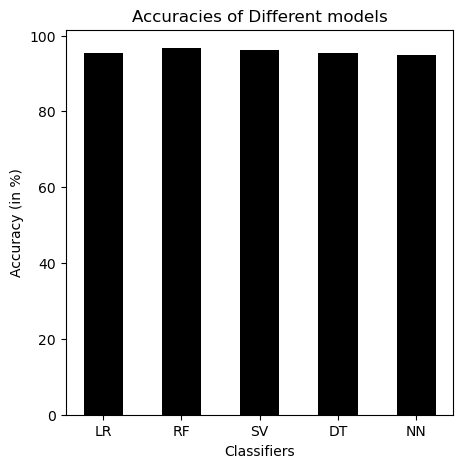

In [201]:
import numpy as np
import matplotlib.pyplot as plt
# Dataset generation
data_dict = {'LR':LRaccuracy, 'RF':RFaccuracy, 'SV':SVaccuracy ,'DT':DTaccuracy, 'NN':NNaccuracy}
courses = list(data_dict.keys())
values = list(data_dict.values())
fig = plt.figure(figsize = (5, 5))
#  Bar plot
plt.bar(courses, values, color ='black',
        width = 0.5)
plt.xlabel("Classifiers")
plt.ylabel("Accuracy (in %)")
plt.title("Accuracies of Different models")
plt.show()

In [238]:
c = X_test[45].reshape(-1,1).T
y = RF.predict(c)
result = ""
if y == [0]:
    result = "Normal"
elif y== [1]:
      result = "Cataract"
print(result)

Normal


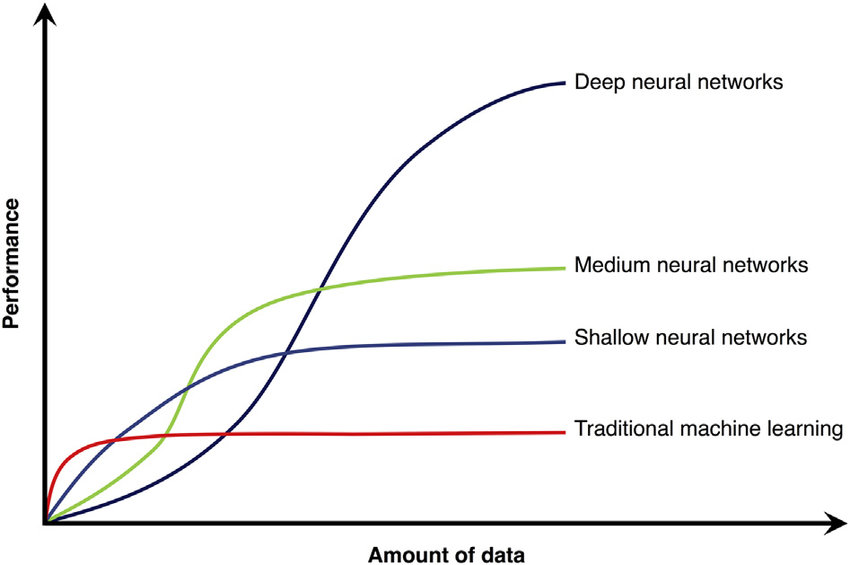

# Building, Training & Testing the NN Model

In [239]:
classifier = Sequential()

layer_info = Dense(activation='relu', input_dim=11, units=50)
classifier.add(layer_info)

# layer_info = Dense(activation='relu', units=6)
# classifier.add(layer_info)

layer_info = Dense(activation='relu', units=30)
classifier.add(layer_info)

layer_info = Dense(activation='sigmoid',units=1)
classifier.add(layer_info)

classifier.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

classifier.fit(X_train, y_train, batch_size=50, epochs=50)

flag_prediction = classifier.predict(X_test).round()

tn, fp, fn, tp = confusion_matrix(y_test, flag_prediction).ravel()

print("True Negative =",tn)
print("False Positive =",fp)
print("False Negative =",fn)
print("True Positive =",tp)


print(confusion_matrix(y_test, flag_prediction))
print(accuracy_score(y_test, flag_prediction)*100)

Epoch 1/50
17/17 [==============================] - 0s 2ms/step - loss: 0.6171 - accuracy: 0.7577
Epoch 2/50
17/17 [==============================] - 0s 1ms/step - loss: 0.4672 - accuracy: 0.8741
Epoch 3/50
17/17 [==============================] - 0s 1ms/step - loss: 0.3826 - accuracy: 0.8812
Epoch 4/50
17/17 [==============================] - 0s 1ms/step - loss: 0.3344 - accuracy: 0.8848
Epoch 5/50
17/17 [==============================] - 0s 1ms/step - loss: 0.3010 - accuracy: 0.8919
Epoch 6/50
17/17 [==============================] - 0s 1ms/step - loss: 0.2732 - accuracy: 0.9014
Epoch 7/50
17/17 [==============================] - 0s 1ms/step - loss: 0.2490 - accuracy: 0.9121
Epoch 8/50
17/17 [==============================] - 0s 1ms/step - loss: 0.2317 - accuracy: 0.9145
Epoch 9/50
17/17 [==============================] - 0s 1ms/step - loss: 0.2167 - accuracy: 0.9157
Epoch 10/50
17/17 [==============================] - 0s 1ms/step - loss: 0.2029 - accuracy: 0.9181
Epoch 11/50
17/17 [